### 12/4 meeting discussion - EDA summary thus far

- two datasets: 360k users/artists/plays and 1k users/artists/tracks/times
    - nan - show up in the mbid category for unknown artists, and in the trackid category for unknown tracks
        - eliminated tracks/trackids up front since they're not being considered
        - ultimately eliminated artists w/o mbid (see below for full discussion)
    - considered several ways to filter down and categorize this data, ultimately settling on mbid
        - artist-name was first consideration
        - artist-name is filthy data (!www.music.com for example)
        - artist naming conventions not the same between the two sets, making deduplication efforts difficult (initial list union was a+b with almost no overlap)
        - if I run artist names through the last.fm API, I get the corrected version back but NO MBID.  this means I have to reverse-engineer the last.fm API auto-correction on my own naming data in order to match back up
        - eliminating artists w/o mbid cuts about 1/3 of my data out, but this is an acceptable loss given the alternative above
        - and either way, since I'm most interested in genre, I want artists with mbid's
- last.fm API pull
    - limited to 1-5 connections per second, need "written permission" to pull more than 100mb
    - list of unique artists from the two datasets is ~186k
    - pulling and matching took all weekend, and I did it without permission, but I'm not banned yet
    - easily saved and extracted from mongo afterwards using similar functions to project 4
- further cleaning in tags_df
    - even using mbid, some come up with no artist data, requiring error exception during extraction 
        - removed about 20,000
    - all tags are user generated, and show up in order of "votes" by users, with a max of 100 genres per artist and 100 votes per tag
        - many have 0 tags (removed about 10,000)
        - many are total garbage w/ 1 vote (NKIBK problem) or are very common but meaningless ('seen live', 'All', 'spotify', 'under 2000 vocalists')
        - **way forward: many less common artists have few tags.  not easy to write a blanket rule to cut off genre tags.  will start by eliminating tags w/ 1 vote and see how many artists it costs, and trade off between the two (graph it out).  build mask.**
- creation of artist_genre_df, a full artist and genre list w/ 4 million entries for the 150k-ish remaining artists
    - expanded error checking algorithm and built a melted dataframe
    - shows 324k unique genres with counts from 1-100
    
- genres per artist graph from genre_df
    - very clean data that shows smooth drop down with spikes at 0/100
- votes per genre per artist graph from artist_genre_df
    - noisier data.  shows that the popular artist/genre combos are well-tagged at 100, but most fall in the 1-20 tags range.  will be useful in later scaling, hopefully
    - maybe build something like a percentage?  this will weigh the large tags heavily but won't overwhelm the lower-tagged artists.  i.e. bandA has 1 tag as 'rock', bandB has 3 tags 'rock','rap','alternative.'  **their weighted total genre representation would 4/3 rock, 1/3 rap, 1/3 alternative instead of 2 rock, 1 rap, 1 alternative. should systematically drown out the NKIBK problem even w/ crappy tags**.  weight instead by # of listens
- genres per user
    - **need to perform some sort of inner join per user.  probably better to generate on the fly than all at once.**
- **clusters of genres by being grouped in similar artists.  not sure how to approach this.  unsupervised learning?  need to be dummies?  label encoder?**
    

### further data cleaning and initial algorithm implementation
- Levenshtein distance
    - although I'm not pulling from a "known good" genre list, I found an implementation of the Levenshtein distance for python online that let me view clusters of like-genres.  it also includes lots of noise, but it allowed me to easily find and eliminate some obvious 2 and 3-character noise and also generate a list to use for replacement
    - I was also able to find and eliminate (manually, unfortunately) a list of bad genres like "favorite", "favorite bands", etc
- I also output all my data to SQL for faster processing on a per-user basis (hopefully)
- Genre Percent
    - before importing to SQL, I implemented my genre percent algorithm to scale each user's genre by the percent of votes of the total that it represents.  this is a version of controlling for variance, and ensures that artists with a high number of genres don't overwhelm the genre profile of a user.  it also does perform a bit of bias against artists that are very popular as signified by a high number of votes

### graphs
- num of genres per user
- timewheel that most users listen (find some way to sample)
- genre similarity - if they appear together on the same artist?

In [22]:
from sklearn.preprocessing import StandardScaler
import pandas as pd, numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt, seaborn as sns
from IPython.display import display
%matplotlib inline
import pickle
from time import sleep
from tqdm import tqdm
import seaborn as sns

In [2]:
import pymongo
import requests
from pymongo import MongoClient

client = pymongo.MongoClient('34.210.38.96', 27016)
db_ref = client['last_fm']
coll_ref = db_ref['lastfm_genres'] 

In [3]:
artist_genre_df = pickle.load( open( "artist_genre_df", "rb" ) ) 


In [4]:
list_of_cats = ['lastfm_genres']

# go through cat list, pull those databases, concat, clean, dedupe
def mongo_pull_clean(list_of_cats): 
    mongo_fields = ['mbid','tag_extract']
    corpus_df = pd.DataFrame()
    for cat in list_of_cats:
        cursor = db_ref[cat].find()
        cat_df = pd.DataFrame(list(cursor), columns = mongo_fields)
        corpus_df = pd.concat([corpus_df, cat_df])
    return corpus_df

In [6]:
# tags_df = mongo_pull_clean(list_of_cats)
tags_df = pickle.load( open( "tags_df", "rb" ) ) 


tags_df.shape

(186960, 2)

In [7]:
tags_df.head()

,mbid,tag_extract
0,NaN,"{'toptags': {'tag': [{'count': 100, 'name': 'h..."
1,NaN,"{'toptags': {'tag': [{'count': 100, 'name': 'h..."
2,c4e269bb-26c7-49c3-ac61-17e6e7ca959c,"{'toptags': {'tag': [{'count': 100, 'name': 'g..."
3,9f6a3740-7c2a-4eaf-ab68-7a8934e1aa04,"{'toptags': {'tag': [{'count': 100, 'name': 't..."
4,039e4715-7886-4098-b45a-65adfbe4a85e,"{'toptags': {'tag': [{'count': 100, 'name': 'f..."


In [ ]:
pickle.dump(tags_df, open('tags_df', "wb" ) )


In [8]:
tags_df.iloc[133109]['tag_extract']

{'toptags': {'@attr': {'artist': 'Straight No Chaser'},
  'tag': [{'count': 100,
    'name': 'a cappella',
    'url': 'https://www.last.fm/tag/a+cappella'},
   {'count': 69,
    'name': 'a capella',
    'url': 'https://www.last.fm/tag/a+capella'},
   {'count': 50,
    'name': 'college a cappella',
    'url': 'https://www.last.fm/tag/college+a+cappella'},
   {'count': 32,
    'name': 'christmas',
    'url': 'https://www.last.fm/tag/christmas'},
   {'count': 32, 'name': 'college', 'url': 'https://www.last.fm/tag/college'},
   {'count': 32,
    'name': 'straight no chaser',
    'url': 'https://www.last.fm/tag/straight+no+chaser'},
   {'count': 19,
    'name': 'male vocalists',
    'url': 'https://www.last.fm/tag/male+vocalists'},
   {'count': 13,
    'name': 'seen live',
    'url': 'https://www.last.fm/tag/seen+live'},
   {'count': 13,
    'name': 'american',
    'url': 'https://www.last.fm/tag/american'},
   {'count': 13,
    'name': 'Acapella',
    'url': 'https://www.last.fm/tag/Acapel

In [9]:
json_response = tags_df.iloc[133109]
json_response

# for i in range(len(json_response['toptags']['tag'])):
#     artist = json_response['toptags']['@attr']['artist']
#     genre = json_response['toptags']['tag'][i]['name']
#     count = json_response['toptags']['tag'][i]['count']
#     print(artist, genre, count)

mbid                        ea6c62ec-701e-4f01-bbcc-adfad2d3be70
tag_extract    {'toptags': {'tag': [{'count': 100, 'name': 'a...
Name: 133109, dtype: object

In [10]:
def mbid_artist(mbid):
    return list(tags_df[tags_df['mbid']==mbid]['tag_extract'])

mbid_artist('4c1321d7-c880-456b-8e9e-2748419fcbaf')

# clearly, those with 100 include mostly bogus tags

[{'toptags': {'@attr': {'artist': 'Ирина Богушевская'},
   'tag': [{'count': 100,
     'name': 'russian',
     'url': 'https://www.last.fm/tag/russian'},
    {'count': 89, 'name': 'jazz', 'url': 'https://www.last.fm/tag/jazz'},
    {'count': 87,
     'name': 'female vocalists',
     'url': 'https://www.last.fm/tag/female+vocalists'},
    {'count': 65, 'name': 'romance', 'url': 'https://www.last.fm/tag/romance'},
    {'count': 64, 'name': 'cabaret', 'url': 'https://www.last.fm/tag/cabaret'},
    {'count': 14,
     'name': 'singer-songwriter',
     'url': 'https://www.last.fm/tag/singer-songwriter'},
    {'count': 9, 'name': 'chanson', 'url': 'https://www.last.fm/tag/chanson'},
    {'count': 7,
     'name': 'seen live',
     'url': 'https://www.last.fm/tag/seen+live'},
    {'count': 7, 'name': 'female', 'url': 'https://www.last.fm/tag/female'},
    {'count': 7, 'name': 'new age', 'url': 'https://www.last.fm/tag/new+age'},
    {'count': 7, 'name': 'tango', 'url': 'https://www.last.fm/tag/

### figure out how many genres each artist has on average

In [ ]:
genre_dict = {}

for index in range(tags_df.shape[0]):
    try:
        json_response = tags_df.iloc[index]
        mbid = json_response['mbid']
        artist = json_response['tag_extract']['toptags']['@attr']['artist']
        num_genres = len(json_response['tag_extract']['toptags']['tag'])
        genre_dict[mbid] = (artist, num_genres)
    except KeyError:
        pass

# genre_dict

In [ ]:
# genre_df = pd.DataFrame.from_dict(genre_dict, orient='index')
genre_df.sort_values(columns, axis=1, ascending=False).sample(15)

In [23]:
# save the genre_df
# pickle.dump(genre_df, open('genre_df', "wb" ) )
genre_df = pickle.load( open( "genre_df", "rb" ) ) 


In [ ]:
genre_df.shape

In [26]:
genre_df.head()

,0,1
NaN,OutCry,38
c4e269bb-26c7-49c3-ac61-17e6e7ca959c,Progeria,29
9f6a3740-7c2a-4eaf-ab68-7a8934e1aa04,qurter,11
039e4715-7886-4098-b45a-65adfbe4a85e,Will Kindler,7
2db5d713-9afc-4966-8a75-7f4b584b3234,ガブリエル・ロベルト,1


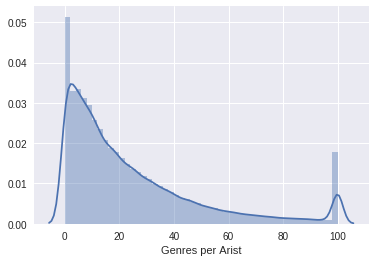

In [27]:
sns.distplot(genre_df[1], axlabel='Genres per Arist')

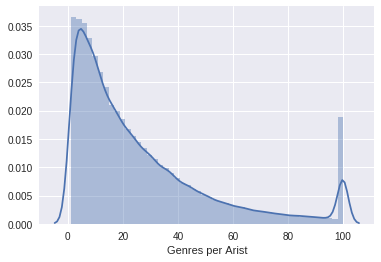

In [28]:
df_no_outliers = genre_df[genre_df[1] !=0]
sns.distplot(df_no_outliers[1], axlabel='Genres per Arist')

In [ ]:
df_no_outliers[1].sum()

# can always update these later, but these are now the genres I'll work with.  
# time to map back on to my original df

In [ ]:
genre_df.head()

### build a df mbid, artist, genre, tag_count

In [ ]:
artist_genre = {}
counter=0

for index in range(tags_df.shape[0]):
    try:
        json_response = tags_df.iloc[index]
        mbid = json_response['mbid']
        artist = json_response['tag_extract']['toptags']['@attr']['artist']
        num_genres = len(json_response['tag_extract']['toptags']['tag'])
        
        if (num_genres !=0):
            for i in range(num_genres):
                genre = json_response['tag_extract']['toptags']['tag'][i]['name']
                count = json_response['tag_extract']['toptags']['tag'][i]['count']  
                artist_genre[counter] = (mbid, artist, genre, count)
                counter += 1
        else:
            pass
    
    except KeyError:
        pass

artist_genre

In [29]:
# artist_genre_df = pd.DataFrame.from_dict(artist_genre, orient='index')
# pickle.dump(artist_genre_df, open('artist_genre_df', "wb" ) )
artist_genre_df = pickle.load( open( "artist_genre_df", "rb" ) ) 


# artist_genre_df.tail(15)

In [ ]:
artist_genre_df.shape

In [5]:
artist_genre_df.head()

,0,1,2,3
0,NaN,OutCry,hardcore,100
1,NaN,OutCry,Melodic Death Metal,80
2,NaN,OutCry,hardcore punk,60
3,NaN,OutCry,youth crew,60
4,NaN,OutCry,metal,40


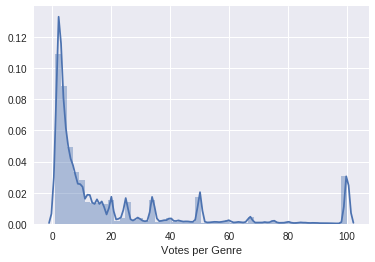

In [30]:
sns.distplot(artist_genre_df[3], axlabel="Votes per Genre")

In [7]:
artist_genre_df[1].nunique()

151499

In [8]:
artist_genre_df[artist_genre_df[1] == 'Opeth'][3].sum()

386

In [ ]:
display(artist_genre_df[2].value_counts())
# out of 4m genre tags, there are 324k unique
# drop 'seen live', 'All', 'spotify', 'under 2000 vocalists', 

In [33]:
test_df = artist_genre_df[~artist_genre_df[2].isin(['seen live', 
                                                    'All', 
                                                    'spotify', 
                                                    'under 2000 listeners',
                                                    'Bands seen Live'
                                                   ])]

In [ ]:
# genres all drop off precipitously with each threshold, but the most gains occur 
# in the early drops.  this cuts genres by 97% while retaining meaningful categories

threshold = 30 # Anything that occurs less than this will be removed.
value_counts = test_df[2].value_counts() # Entire DataFrame 
to_remove = value_counts[value_counts <= threshold].index

In [ ]:
list(to_remove)

In [ ]:
artist_genre_df2 = test_df[~test_df[2].isin(list(to_remove))]

In [31]:
# pickle.dump(artist_genre_df2, open('artist_genre_df2', "wb" ) )
artist_genre_df2 = pickle.load( open( "artist_genre_df2", "rb" ) ) 

In [10]:
artist_genre_df2.shape

(3044580, 4)

In [11]:
artist_genre_df2[1].nunique()

149528

In [12]:
# cutting out at a threshold of 30 eliminated about 2000 artists.  might revisit later if 
# it doesn't cost much computationally to redo

In [14]:
artist_genre_df2.tail(20)

,0,1,2,3
4014537,bb83fb59-a62c-4d82-a38d-50177cd34207,Monika,underrated,3
4014539,bb83fb59-a62c-4d82-a38d-50177cd34207,Monika,female singer,3
4014540,bb83fb59-a62c-4d82-a38d-50177cd34207,Monika,whore,3
4014541,bb83fb59-a62c-4d82-a38d-50177cd34207,Monika,radio paradise,3
4014542,bb83fb59-a62c-4d82-a38d-50177cd34207,Monika,radioparadise,3
4014543,bb83fb59-a62c-4d82-a38d-50177cd34207,Monika,10s,3
4014544,bb83fb59-a62c-4d82-a38d-50177cd34207,Monika,Brutal Death Metal,3
4014545,bb83fb59-a62c-4d82-a38d-50177cd34207,Monika,kgrl,3
4014546,bb83fb59-a62c-4d82-a38d-50177cd34207,Monika,voz,3
4014548,bb83fb59-a62c-4d82-a38d-50177cd34207,Monika,chalga,3


In [38]:
freq_genres = []
for i in range(0, 500, 5):
    freq_genres.append((i, (test_df[2].value_counts()>i).sum()))
    print(i, (test_df[2].value_counts()>i).sum())

0 324019
5 45133
10 27419
15 20014
20 15843
25 13237
30 11368
35 9967
40 8887
45 8057
50 7327
55 6768
60 6255
65 5813
70 5442
75 5148
80 4871
85 4614
90 4383
95 4193
100 4052
105 3882
110 3714
115 3581
120 3441
125 3329
130 3218
135 3111
140 3005
145 2887
150 2799
155 2716
160 2634
165 2573
170 2482
175 2414
180 2350
185 2307
190 2250
195 2197
200 2131
205 2083
210 2038
215 2004
220 1962
225 1926
230 1900
235 1870
240 1834
245 1806
250 1774
255 1739
260 1712
265 1686
270 1660
275 1640
280 1611
285 1587
290 1563
295 1535
300 1516
305 1486
310 1460
315 1436
320 1413
325 1395
330 1378
335 1351
340 1331
345 1314
350 1297
355 1289
360 1268
365 1253
370 1235
375 1219
380 1200
385 1182
390 1168
395 1154
400 1137
405 1119
410 1109
415 1096
420 1074
425 1060
430 1049
435 1036
440 1022
445 1002
450 993
455 985
460 975
465 962
470 951
475 939
480 928
485 912
490 901
495 893


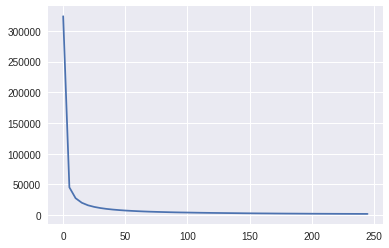

In [40]:
x_list = []
y_list = []

for x in range(50):
    x_list.append(freq_genres[x][0])
    
for y in range(50):
    y_list.append(freq_genres[y][1])
    
plt.plot(x_list, y_list)

plt.xlabel = 'threshold'
plt.ylabel = 'unique genres remaining'

### build mask to selectively drop low-value tags and shitty tags

### figure out if it's better to join these or process/lookup separately

In [8]:
# lastfm_1k = pickle.load( open( "lastfm_1kmb", "rb" ) ) 
# lastfm_360k = pickle.load( open( "lastfm_360kmb", "rb" ) ) 
artist_genre_df2 = pickle.load( open( "artist_genre_df2", "rb" ) ) 

In [16]:

import sqlite3
con = sqlite3.connect("lastfm_1k_sql")

# lastfm_1k.to_sql(con=con, name='lastfm_1k_sql', if_exists='replace', flavor='sqlite')
# lastfm_360k.to_sql(con=con, name='lastfm_360k_sql', if_exists='replace', flavor='sqlite')
artist_genre_df2.to_sql(con=con, name='artist_genre_df2_sql', if_exists='replace', flavor='sqlite')

/opt/conda/lib/python3.6/site-packages/pandas/io/sql.py:525: FutureWarning: the 'flavor' parameter is deprecated and will be removed in a future version, as 'sqlite' is the only supported option when SQLAlchemy is not installed.
  _validate_flavor_parameter(flavor)


In [17]:
artist='Radiohead'

artist_genre_df2.rename(columns={0: 'artmbid', 1: 'artname', 2:'genre', 3:'genre_votes'}, inplace=True)
artist_genre_df2['genre_percent'] = np.NaN
artist_genre_df2[artist_genre_df2['artname'] == artist] 


,artmbid,artname,genre,genre_votes,genre_percent
318715,a74b1b7f-71a5-4011-9441-d0b5e4122711,Radiohead,alternative,100,NaN
318716,a74b1b7f-71a5-4011-9441-d0b5e4122711,Radiohead,alternative rock,81,NaN
318717,a74b1b7f-71a5-4011-9441-d0b5e4122711,Radiohead,rock,73,NaN
318718,a74b1b7f-71a5-4011-9441-d0b5e4122711,Radiohead,indie,59,NaN
318719,a74b1b7f-71a5-4011-9441-d0b5e4122711,Radiohead,electronic,48,NaN
318721,a74b1b7f-71a5-4011-9441-d0b5e4122711,Radiohead,british,22,NaN
318722,a74b1b7f-71a5-4011-9441-d0b5e4122711,Radiohead,britpop,17,NaN
318723,a74b1b7f-71a5-4011-9441-d0b5e4122711,Radiohead,indie rock,15,NaN
318724,a74b1b7f-71a5-4011-9441-d0b5e4122711,Radiohead,experimental,14,NaN
318725,a74b1b7f-71a5-4011-9441-d0b5e4122711,Radiohead,radiohead,11,NaN


In [56]:
unique_artists = artist_genre_df2['artname'].unique()

In [58]:
for artist in tqdm(unique_artists):
    # total votes and series of percents for artist
    total_votes = artist_genre_df2[artist_genre_df2['artname'] == artist]['genre_votes'].sum() 
    total_percent = artist_genre_df2[artist_genre_df2['artname'] == artist]['genre_votes'].apply(lambda x: x/total_votes).copy()

    # set the genre_percent column equal to the series above
    artist_genre_df2.loc[artist_genre_df2['artname'] == artist, "genre_percent"] = total_percent

# artist = 'Radiohead'
# list everything for given artist
# artist_genre_df2[artist_genre_df2['artname'] == artist] 

# list of genres for artist
# artist_genre_df2[artist_genre_df2['artname'] == artist]['genre']

# genre_percent generator
# artist_genre_df2[artist_genre_df2['artname'] == artist]['genre_percent'] = artist_genre_df2[artist_genre_df2['artname'] == artist]['genre_votes'].div(1000)
# artist_genre_df2[artist_genre_df2['artname'] == artist].loc[:, 'genre_percent'] = artist_genre_df2[artist_genre_df2['artname'] == artist]['genre_votes'].\
# apply(lambda x: x/total_votes)


# artist_genre_df2[artist_genre_df2['artname'] == artist]


  4%|▍         | 6461/149528 [1:10:08<25:53:14,  1.54it/s]

KeyboardInterrupt: 

In [18]:
artist_genre_percent.head()

NameError: name 'artist_genre_percent' is not defined

In [24]:
# find the total number of votes given to genres for a given artist
genre_sum_lookup = artist_genre_percent.groupby("artname")["genre_votes"].sum()

# output the percentage of votes that each genre received compared to the total
# this will selectively reduce the weight of genres on popular artists, and selectively
# reduce the weight of junk genres on individual artists
artist_genre_percent["genre_percent"] = artist_genre_percent.apply\
    (lambda x: x["genre_votes"] / genre_sum_lookup[x["artname"]], axis = 1)


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [28]:
artist_genre_percent[artist_genre_df2['artname'].isnull()]

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,artmbid,artname,genre,genre_votes,genre_percent


### saving the post-processing

In [11]:
pickle.dump(artist_genre_df2, open('artist_genre_percent', "wb" ) )

In [21]:
# import sqlite3
# con = sqlite3.connect("lastfm_1k_sql")

# artist_genre_percent = pickle.load( open( "artist_genre_percent", "rb" ) ) 
# pickle.dump(artist_genre_percent, open('artist_genre_percent', "wb" ) )
artist_genre_percent.to_sql(con=con, name='artist_genre_percent_sql', if_exists='replace')

In [20]:
artist_genre_percent[artist_genre_percent['artname'] == artist] 

,artmbid,artname,genre,genre_votes,genre_percent
318715,a74b1b7f-71a5-4011-9441-d0b5e4122711,Radiohead,alternative,100,0.198020
318716,a74b1b7f-71a5-4011-9441-d0b5e4122711,Radiohead,alternative rock,81,0.160396
318717,a74b1b7f-71a5-4011-9441-d0b5e4122711,Radiohead,rock,73,0.144554
318718,a74b1b7f-71a5-4011-9441-d0b5e4122711,Radiohead,indie,59,0.116832
318719,a74b1b7f-71a5-4011-9441-d0b5e4122711,Radiohead,electronic,48,0.095050
318721,a74b1b7f-71a5-4011-9441-d0b5e4122711,Radiohead,british,22,0.043564
318722,a74b1b7f-71a5-4011-9441-d0b5e4122711,Radiohead,britpop,17,0.033663
318723,a74b1b7f-71a5-4011-9441-d0b5e4122711,Radiohead,indie rock,15,0.029703
318724,a74b1b7f-71a5-4011-9441-d0b5e4122711,Radiohead,experimental,14,0.027723
318725,a74b1b7f-71a5-4011-9441-d0b5e4122711,Radiohead,radiohead,11,0.021782


In [15]:
unique_genre = artist_genre_percent['genre'].unique()

In [30]:
unique_genre_list = list(np.sort(unique_genre))
len(unique_genre_list)

11188

In [17]:
# from https://www.stavros.io/posts/finding-the-levenshtein-distance-in-python/
# https://stackoverflow.com/questions/37405954/levenshtein-distance-for-a-list

def levenshtein(first, second):
    """Find the Levenshtein distance between two strings."""
    if len(first) > len(second):
        first, second = second, first
    if len(second) == 0:
        return len(first)
    first_length = len(first) + 1
    second_length = len(second) + 1
    distance_matrix = [[0] * second_length for x in range(first_length)]
    for i in range(first_length):
        distance_matrix[i][0] = i
    for j in range(second_length):
        distance_matrix[0][j]=j
    for i in range(1, first_length):
        for j in range(1, second_length):
            deletion = distance_matrix[i-1][j] + 1
            insertion = distance_matrix[i][j-1] + 1
            substitution = distance_matrix[i-1][j-1]
            if first[i-1] != second[j-1]:
                substitution += 1
            distance_matrix[i][j] = min(insertion, deletion, substitution)
    return distance_matrix[first_length-1][second_length-1]

def return_clusters(unique_genre_list, threshold1):
    words = unique_genre_list
    threshold = threshold1
    clusters = \
        {w1: set(w2 for w2 in words if levenshtein(w1, w2) <= threshold) for w1 in tqdm(words)}
    
    clusters_dict = {key: value for key, value in clusters.items() 
        if len(value) is not 1}
    
    return clusters_dict


In [18]:
clusters_1 = return_clusters(unique_genre_list[:1000], 1)   
clusters_2 = return_clusters(unique_genre_list[1000:2000], 1)   
clusters_3 = return_clusters(unique_genre_list[2000:3000], 1)   
clusters_4 = return_clusters(unique_genre_list[3000:4000], 1)   
clusters_5 = return_clusters(unique_genre_list[4000:5000], 1)   
clusters_6 = return_clusters(unique_genre_list[5000:6000], 1)   
clusters_7 = return_clusters(unique_genre_list[6000:7000], 1)   
clusters_8 = return_clusters(unique_genre_list[7000:8000], 1)   
clusters_9 = return_clusters(unique_genre_list[8000:9000], 1)   
clusters_10 = return_clusters(unique_genre_list[9000:10000], 1)   
clusters_11 = return_clusters(unique_genre_list[10000:11000], 1) 
clusters_12 = return_clusters(unique_genre_list[11000:11188], 1)   

clusters = {}
clusters.update(clusters_1)
clusters.update(clusters_2)
clusters.update(clusters_3)
clusters.update(clusters_4)
clusters.update(clusters_5)
clusters.update(clusters_6)
clusters.update(clusters_7)
clusters.update(clusters_8)
clusters.update(clusters_9)
clusters.update(clusters_10)
clusters.update(clusters_11)
clusters.update(clusters_12)

100%|██████████| 188/188 [00:02<00:00, 89.65it/s]


In [19]:
clusters

{' rock': {' rock', 'Brock'},
 "'00s": {"'00s", "'70s", "'80s", "'90s", '00s'},
 "'70s": {"'00s", "'70s", "'80s", "'90s", '70s'},
 "'80s": {"'00s", "'70s", "'80s", "'90s", '80s'},
 "'90s": {"'00s", "'70s", "'80s", "'90s", '90s'},
 '-listen': {'-listen', '0listen', '2listen'},
 "00's": {"00's", '00s', "50's", "60's", "70's", "80's", "90's"},
 '000': {'000', '001', '00s', '100', '2000'},
 '001': {'000', '001', '00s', '2001'},
 '00s': {"'00s",
  "00's",
  '000',
  '001',
  '00s',
  '10s',
  '20s',
  '30s',
  '40s',
  '50s',
  '60s',
  '70s',
  '80s',
  '90s'},
 '00s pop': {'00s pop', '10s pop', '60s pop', '70s pop', '90s pop'},
 '00s rock': {'00s rock', '60s rock', '70s rock', '80s rock'},
 '0listen': {'-listen', '0listen', '2listen'},
 '100': {'000', '100', '10s'},
 '10s': {'00s',
  '100',
  '10s',
  '20s',
  '30s',
  '40s',
  '50s',
  '60s',
  '70s',
  '80s',
  '90s'},
 '10s pop': {'00s pop', '10s pop', '60s pop', '70s pop', '90s pop'},
 '123': {'123', '12k'},
 '12k': {'123', '12k'},
 '

In [20]:
len(clusters)

2282

In [31]:
pickle.dump(unique_genre_list, open('unique_genre_list', "wb" ) )

In [3]:
delete_list = [
'seen live', 
'All', 
'spotify', 
'under 2000 listeners',
'Bands seen Live',
'Band I want to hear more of',
'Bandcamp',
'Bands I Like',
'Bands I Wish I Had Seen Live',
'Bands I have seen live',
'Bands I seen Live',
'Bands to look into',
'Bands to watch',
'Best Band EVER',
'Check Them Out',
'Check it out',
'Check out more',
'Check out sometimes',
'Checking out',
' ','-',
'0',
'00',
'1',
'10',
'11',
'12',
'13',
'14',
'15',
'16',
'17',
'18',
'19',
'2',
'20',
'21',
'22',
'23',
'24',
'25',
'27',
'28',
'29',
'3',
'30',
'31',
'32',
'33',
'34',
'35',
'36',
'37',
'38',
'39',
'4',
'40',
'42',
'43',
'44',
'45',
'46',
'47',
'48',
'49',
'5',
'50',
'59',
'6',
'60',
'61',
'66',
'7',
'70',
'74',
'75',
'76',
'77',
'8',
'80',
'81',
'87',
'88',
'9',
'90',
'92',
'96',
'98',
'99',
':3',
':D',
'<3',
'ACDC',
'BG',
'C',
'CA',
'CC',
'CT',
'Ch',
'DAC',
'DC',
'DE',
'DL',
'Dan',
'Dio',
'Fave','Faves',
'Favorite',
'Favorite Artists',
'Favorite Bands',
'Favorite artist',
'Favoritos',
'Favourite Band',
'Favourite bands',
'Favourites',
'Less than 200000',
'Less than 200000',
'Less than 30000',
'Less than 400000',
'Less than 30000',
'Less than 200000',
'Less than 30000',
'Less than 400000',
'Less than 400000',
'Less than 200000',
'Less than 30000',
'Less than 400000',
'Like', 
'Laika', 
'Laiko', 
'Like', 
'Likes',
'Love',
'Local',
    'Fecal', 'Local', 'Lojah',
'Local Bands',
    'Local Bands', 'Local band',
'Local band',
    'Local Bands', 'Local band',
'My Favorites',
    'My Favorites', 'My Favourites',
'My Favourites',
    'My Favorites', 'My Favourites', 'My favourite',
'My Favs',
    'My Favs', 'My Tags', 'MyFav',
'My Tags',
    'My Favs', 'My Tags', 'My tag',
'My artists',
    'My artists', 'UK artists',
'My favorite bands',
    'My favorite bands', 'My favourite bands',
'My favourite',
    'My Favourites', 'My favourite',
'My favourite bands',
    'My favorite bands', 'My favourite bands',
'My tag',
    'My Tags', 'My tag',
'MyFav',
    'My Favs', 'MyFav',
'Q4',
'My',
'NC',
'NJ',
'NL',
'NU',
'OC',
'OT',
'Oi',
'PA',
'PL',
'Q4',
'QB',
'R',
'RB',
'RX',
'SK',
'SP',
'TX',
'To',
'U2',
'UR',
'QB',
'My',
  'NC',
  'NJ',
  'NL',
  'NU',
  'OC',
  'OT',
  'Oi',
  'PA',
  'PL',
  'Q4',
  'QB',
  'R',
  'RB',
  'RX',
  'SK',
  'SP',
  'TBL',
  'TX',
  'To',
  'U2',
  'UR',
'VA','VA', 'VK', 'WP', 'XVX', 'Y', 'YE', 'a', 'aa', 'au', 'b','a','VA',
  'VK',
  'WP',
  'Y',
  'YE',
  'Yay',
  'a',
  'aa',
  'aaa',
  'abc',
  'ace',
  'add',
  'aeo',
  'ali',
  'alt',
  'and',
  'art',
  'ass',
  'atb',
  'au',
  'b',
  'bad',
  'bar',
]

# come up with a replacement list too

In [12]:
artist_genre_df2.head()

,artmbid,artname,genre,genre_votes,genre_percent
0,NaN,OutCry,hardcore,100,NaN
1,NaN,OutCry,Melodic Death Metal,80,NaN
2,NaN,OutCry,hardcore punk,60,NaN
3,NaN,OutCry,youth crew,60,NaN
4,NaN,OutCry,metal,40,NaN


In [13]:
artist_genre_percent = artist_genre_df2[~artist_genre_df2['genre'].isin(delete_list)]

In [ ]:
artist_genre_percent_filtered = \
artist_genre_percent.loc[(artist_genre_percent['genre_percent'] >= 0.2) | (artist_genre_percent['genre_votes'] == 100)]

artist_genre_percent_filtered.shape
artist_genre_percent_filtered[artist_genre_percent_filtered['genre_votes'] != 100].shape

In [ ]:
artist_genre_percent_filtered.to_sql(con=con, 
                                     name='artist_genre_percent_filtered', 
                                     if_exists='replace')


In [ ]:
sns.distplot(artist_genre_percent_filtered['genre_percent'])

### clusters of genres related via being on the same artist

In [ ]:
# unsupervised learning to determine clusters?  somehow need to numerify them